In [1]:
# Just to know last time this was run:
import time
print time.ctime()

Wed Oct 26 16:19:03 2016


# H Optimizing code writing

This is part of the Python lecture given by Christophe Morisset at IA-UNAM. More informations at: http://python-astro.blogspot.mx/

In [2]:
import numpy as np
from IPython.core.display import Image

### Profiling the code: CPU usage

In [3]:
%%writefile test_1_prof.py

import numpy as np
import os
import urllib2
from scipy.integrate import simps

class Stel_Spectrum(object):
    """
    This object downloads a file from http://astro.uni-tuebingen.de/~rauch/TMAF/NLTE/He+C+N+O/
    and is able to make some plots.    
    """
    
    spec_count = 0 # This attibute is at the level of the class, not of the object.
    def __init__(self, filename=None, T=None, logg=None, verbose=False):
        """
        Initialisation of the Stel_Spectrum object.
        Parameter:
            - filename
            - T: temperature in K, e.g. 150000
            - logg: e.g. 7.5
            - verbose: if True, some info are printed out
        The wl variable is an array of wavelengths in Angstrom.
        The fl variable is the flux in erg/s/cm2/A
        The variables T and logg are properties: changing them will reload the data
        """
        self.verbose = verbose
        if filename is None:
            if T is not None and logg is not None:
                self.__T = T # We need to initialize the hidden values, as logg is still not defined
                self.logg = logg
                self.filename = '0{0:06.0f}_{1:.2f}_33_50_02_15.bin_0.1.gz'.format(self.T, self.logg)
            else:
                raise TypeError("T and logg must be given")
        else:
            self.filename = filename
            self.__T = float(filename.split('_')[0]) # We need to initialize the hidden values, as logg is still not defined
            self.logg = float(filename.split('_')[1])
        Stel_Spectrum.spec_count += 1
        if self.verbose:
            print('Instantiation done')
            
    def dlfile(self):
        """
        Downloading file if not already here. Put it in the current directory
        """
        if not os.path.exists(self.filename):
            if self.verbose:
                print('Downloading {}'.format(self.filename))
            try:
                stel_file = urllib2.urlopen('http://astro.uni-tuebingen.de/~rauch/TMAF/NLTE/He+C+N+O/' + 
                                            self.filename)
                output = open(self.filename,'wb')
                output.write(stel_file.read())
                output.close()
                self.file_found=True
            except:
                if self.verbose:
                    print('file {} not found'.format(self.filename))
                self.file_found=False
        else:
            if self.verbose:
                print('{} already on disk'.format(self.filename))
            self.file_found=True
                
    def read_data(self):
        """
        read the data from the file
        """
        if self.file_found:
            data = np.genfromtxt(self.filename, comments='*', names='wl, fl')
            self.fl = data['fl']
            self.wl = data['wl'] # in A
            self.fl /= 1e8 # F LAMBDA  GIVEN IN ERG/CM**2/SEC/CM -> erg/s/cm2/A
            if self.verbose:
                print('Read data from {}'.format(self.filename))
        else:
            if self.verbose:
                print('file not found {}'.format(self.filename))
            self.wl = None
            self.fl = None
        
    def plot_spr(self, ax=None, *args, **kwargs):
        """
        Plot the spectrum.
        Parameter:
            - ax: an axis (optionnal). If Noe or absent, axis is created
            - any extra parameter is passed to ax.plot
        """
        if self.wl is None:
            print('No data to plot')
            return
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(self.wl, self.fl,
                label='T3={0:.0f}, logg={1}'.format(self.T/1e3, self.logg),
                *args, **kwargs) # Here are the transmissions of extra parameters to plot
        ax.set_yscale('log')
        ax.set_ylim(1e6, 1e14)
        ax.set_xlabel('Wavelength (A)')
        
    def get_integ(self):
        """
        Return the integral of Flambda over lambda, in erg/s/cm2
        """
        if self.wl is None:
            print('No data')
            return None
        return simps(self.fl, self.wl) # perform the integral
    
    def __getT(self): 
        return self.__T
    
    def __setT(self, value): 
        if not isinstance(value, (int, long, float)): # check the type of the input
            raise TypeError('T must be an integer or a float')
        if float(value) not in np.linspace(40000, 190000, 16): # check the value of the input
            raise ValueError('T value must be between 40000 and 190000K, by 10000K steps')
        elif self.__T != value:
            self.__T = value
            self.filename = '0{0:06.0f}_{1:.2f}_33_50_02_15.bin_0.1.gz'.format(self.T, self.logg)
            self.dlfile() # will download new data
            self.read_data() # will update the data
        
    def __delT(self): 
        print('T is needed')
        
    T = property(__getT, __setT, __delT, "Stellar effective temperature")
    
    def __getlogg(self): 
        return self.__logg
    
    def __setlogg(self, value):
        try:
            self.__logg 
        except:
            self.__logg = -1
        if not isinstance(value, (int, long, float)):
            raise TypeError('logg must be an integer or a float')
        if float(value) not in (-1., 5., 6., 7. ,8., 9.):
            raise ValueError('Error, logg must be 6, 7, 8, or 9')
            self.__logg = None
        elif self.__logg != value:
            self.__logg = value
            self.filename = '0{0:06.0f}_{1:.2f}_33_50_02_15.bin_0.1.gz'.format(self.T, self.logg)
            self.dlfile() # will download new data
            self.read_data() # will update the data
        
    def __dellogg(self): 
        print('logg is needed')
        
    logg = property(__getlogg, __setlogg, __dellogg, "Stellar logg")

    def print_info(self):
        """
        Print out the filename and the number of points
        """
        print self.__repr__()
        
    def __repr__(self):
        """
        This is what is used when calling "print <obj>" or <obj> ENTER
        """
        if self.wl is None:
            return'Filename: {0}, No data'.format(self.filename)
        else:
            return'Filename: {0}, number of points: {1}'.format(self.filename, len(self.wl))
    
    def __del__(self):
        Stel_Spectrum.spec_count -= 1

spectra = [] # we create an empty list
for T in np.linspace(40000, 190000, 4): # this is the list of available temperature (check the site)
    spectra.append(Stel_Spectrum(T=T, logg=6, verbose=True)) # we fill the list with the objects for each temperature
T = np.array([sp.T for sp in spectra])
F = np.array([sp.get_integ() for sp in spectra])
for t, f in zip(T, F):
    print('Temperature = {0:.0f}K, Flux = {1:.2e} erg/s/cm2'.format(t, f))



Overwriting test_1_prof.py


In [4]:
%run -t test_1_prof.py

0040000_6.00_33_50_02_15.bin_0.1.gz already on disk
Read data from 0040000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
0090000_6.00_33_50_02_15.bin_0.1.gz already on disk
Read data from 0090000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
0140000_6.00_33_50_02_15.bin_0.1.gz already on disk
Read data from 0140000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
0190000_6.00_33_50_02_15.bin_0.1.gz already on disk
Read data from 0190000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
Temperature = 40000K, Flux = 4.00e+13 erg/s/cm2
Temperature = 90000K, Flux = 1.05e+15 erg/s/cm2
Temperature = 140000K, Flux = 6.93e+15 erg/s/cm2
Temperature = 190000K, Flux = 2.35e+16 erg/s/cm2

IPython CPU timings (estimated):
  User   :       0.41 s.
  System :       0.09 s.
Wall time:       0.66 s.


In [5]:
%run -p test_1_prof.py

0040000_6.00_33_50_02_15.bin_0.1.gz already on disk
Read data from 0040000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
0090000_6.00_33_50_02_15.bin_0.1.gz already on disk
Read data from 0090000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
0140000_6.00_33_50_02_15.bin_0.1.gz already on disk
Read data from 0140000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
0190000_6.00_33_50_02_15.bin_0.1.gz already on disk
Read data from 0190000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
Temperature = 40000K, Flux = 4.00e+13 erg/s/cm2
Temperature = 90000K, Flux = 1.05e+15 erg/s/cm2
Temperature = 140000K, Flux = 6.93e+15 erg/s/cm2
Temperature = 190000K, Flux = 2.35e+16 erg/s/cm2
 

In [6]:
# Inserting @profile before some functions leads to detailed report on the corresponding functions

In [6]:
%%writefile test_2_prof.py

import numpy as np
import os
import urllib2
from scipy.integrate import simps

class Stel_Spectrum(object):
    """
    This object downloads a file from http://astro.uni-tuebingen.de/~rauch/TMAF/NLTE/He+C+N+O/
    and is able to make some plots.    
    """
    
    spec_count = 0 # This attibute is at the level of the class, not of the object.
    
    @profile
    def __init__(self, filename=None, T=None, logg=None, verbose=False):
        """
        Initialisation of the Stel_Spectrum object.
        Parameter:
            - filename
            - T: temperature in K, e.g. 150000
            - logg: e.g. 7.5
            - verbose: if True, some info are printed out
        The wl variable is an array of wavelengths in Angstrom.
        The fl variable is the flux in erg/s/cm2/A
        The variables T and logg are properties: changing them will reload the data
        """
        self.verbose = verbose
        if filename is None:
            if T is not None and logg is not None:
                self.__T = T # We need to initialize the hidden values, as logg is still not defined
                self.logg = logg
                self.filename = '0{0:06.0f}_{1:.2f}_33_50_02_15.bin_0.1.gz'.format(self.T, self.logg)
            else:
                raise TypeError("T and logg must be given")
        else:
            self.filename = filename
            self.__T = float(filename.split('_')[0]) # We need to initialize the hidden values, as logg is still not defined
            self.logg = float(filename.split('_')[1])
        Stel_Spectrum.spec_count += 1
        if self.verbose:
            print('Instantiation done')

    @profile
    def dlfile(self):
        """
        Downloading file if not already here. Put it in the current directory
        """
        if not os.path.exists(self.filename):
            if self.verbose:
                print('Downloading {}'.format(self.filename))
            try:
                stel_file = urllib2.urlopen('http://astro.uni-tuebingen.de/~rauch/TMAF/NLTE/He+C+N+O/' + 
                                            self.filename)
                output = open(self.filename,'wb')
                output.write(stel_file.read())
                output.close()
                self.file_found=True
            except:
                if self.verbose:
                    print('file {} not found'.format(self.filename))
                self.file_found=False
        else:
            if self.verbose:
                print('{} already on disk'.format(self.filename))
            self.file_found=True
    
    @profile
    def read_data(self):
        """
        read the data from the file
        """
        if self.file_found:
            data = np.genfromtxt(self.filename, comments='*', names='wl, fl')
            self.fl = data['fl']
            self.wl = data['wl'] # in A
            self.fl /= 1e8 # F LAMBDA  GIVEN IN ERG/CM**2/SEC/CM -> erg/s/cm2/A
            if self.verbose:
                print('Read data from {}'.format(self.filename))
        else:
            if self.verbose:
                print('file not found {}'.format(self.filename))
            self.wl = None
            self.fl = None
        
    def plot_spr(self, ax=None, *args, **kwargs):
        """
        Plot the spectrum.
        Parameter:
            - ax: an axis (optionnal). If Noe or absent, axis is created
            - any extra parameter is passed to ax.plot
        """
        if self.wl is None:
            print('No data to plot')
            return
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(self.wl, self.fl,
                label='T3={0:.0f}, logg={1}'.format(self.T/1e3, self.logg),
                *args, **kwargs) # Here are the transmissions of extra parameters to plot
        ax.set_yscale('log')
        ax.set_ylim(1e6, 1e14)
        ax.set_xlabel('Wavelength (A)')
        
    def get_integ(self):
        """
        Return the integral of Flambda over lambda, in erg/s/cm2
        """
        if self.wl is None:
            print('No data')
            return None
        return simps(self.fl, self.wl) # perform the integral
    
    def __getT(self): 
        return self.__T
    
    def __setT(self, value): 
        if not isinstance(value, (int, long, float)): # check the type of the input
            raise TypeError('T must be an integer or a float')
        if float(value) not in np.linspace(40000, 190000, 16): # check the value of the input
            raise ValueError('T value must be between 40000 and 190000K, by 10000K steps')
        elif self.__T != value:
            self.__T = value
            self.filename = '0{0:06.0f}_{1:.2f}_33_50_02_15.bin_0.1.gz'.format(self.T, self.logg)
            self.dlfile() # will download new data
            self.read_data() # will update the data
        
    def __delT(self): 
        print('T is needed')
        
    T = property(__getT, __setT, __delT, "Stellar effective temperature")
    
    def __getlogg(self): 
        return self.__logg

    @profile
    def __setlogg(self, value):
        try:
            self.__logg 
        except:
            self.__logg = -1
        if not isinstance(value, (int, long, float)):
            raise TypeError('logg must be an integer or a float')
        if float(value) not in (-1., 5., 6., 7. ,8., 9.):
            raise ValueError('Error, logg must be 6, 7, 8, or 9')
            self.__logg = None
        elif self.__logg != value:
            self.__logg = value
            self.filename = '0{0:06.0f}_{1:.2f}_33_50_02_15.bin_0.1.gz'.format(self.T, self.logg)
            self.dlfile() # will download new data
            self.read_data() # will update the data
        
    def __dellogg(self): 
        print('logg is needed')
        
    logg = property(__getlogg, __setlogg, __dellogg, "Stellar logg")

    def print_info(self):
        """
        Print out the filename and the number of points
        """
        print self.__repr__()
        
    def __repr__(self):
        """
        This is what is used when calling "print <obj>" or <obj> ENTER
        """
        if self.wl is None:
            return'Filename: {0}, No data'.format(self.filename)
        else:
            return'Filename: {0}, number of points: {1}'.format(self.filename, len(self.wl))
    
    def __del__(self):
        Stel_Spectrum.spec_count -= 1

spectra = [] # we create an empty list
for T in np.linspace(40000, 190000, 4): # this is the list of available temperature (check the site)
    spectra.append(Stel_Spectrum(T=T, logg=6, verbose=True)) # we fill the list with the objects for each temperature
T = np.array([sp.T for sp in spectra])
F = np.array([sp.get_integ() for sp in spectra])
for t, f in zip(T, F):
    print('Temperature = {0:.0f}K, Flux = {1:.2e} erg/s/cm2'.format(t, f))

Overwriting test_2_prof.py


In [10]:
# Need to pip install line-profiler
! kernprof -l -v test_2_prof.py

Read data from 0040000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
Read data from 0090000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
Read data from 0140000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
Read data from 0190000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
Temperature = 40000K, Flux = 4.00e+13 erg/s/cm2
Temperature = 90000K, Flux = 1.05e+15 erg/s/cm2
Temperature = 140000K, Flux = 6.93e+15 erg/s/cm2
Temperature = 190000K, Flux = 2.35e+16 erg/s/cm2
Wrote profile results to test_2_prof.py.lprof
Timer unit: 1e-06 s

Total time: 8.13196 s
File: test_2_prof.py
Function: __init__ at line 15

Line #      Hits         Time  Per Hit   % Time  Line Contents
    15                                               @profile
    16                                               def __init__(self, filename=None, T=None, logg=None, verbose=False):
    17                                                   """
    18                                                   Initialisation of th

In [17]:
# Use the test_1 because @profile is not compatible
! python -m cProfile -o test_1_prof.prof test_1_prof.py

0040000_6.00_33_50_02_15.bin_0.1.gz already on disk
Read data from 0040000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
0090000_6.00_33_50_02_15.bin_0.1.gz already on disk
Read data from 0090000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
0140000_6.00_33_50_02_15.bin_0.1.gz already on disk
Read data from 0140000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
0190000_6.00_33_50_02_15.bin_0.1.gz already on disk
Read data from 0190000_6.00_33_50_02_15.bin_0.1.gz
Instantiation done
Temperature = 40000K, Flux = 4.00e+13 erg/s/cm2
Temperature = 90000K, Flux = 1.05e+15 erg/s/cm2
Temperature = 140000K, Flux = 6.93e+15 erg/s/cm2
Temperature = 190000K, Flux = 2.35e+16 erg/s/cm2


In [18]:
# need to pip install gprof2dot
# dot is installed by sudo yum/dnf install graphviz
! gprof2dot -f pstats test_1_prof.prof | dot -Tpng -o test_1-prof.png

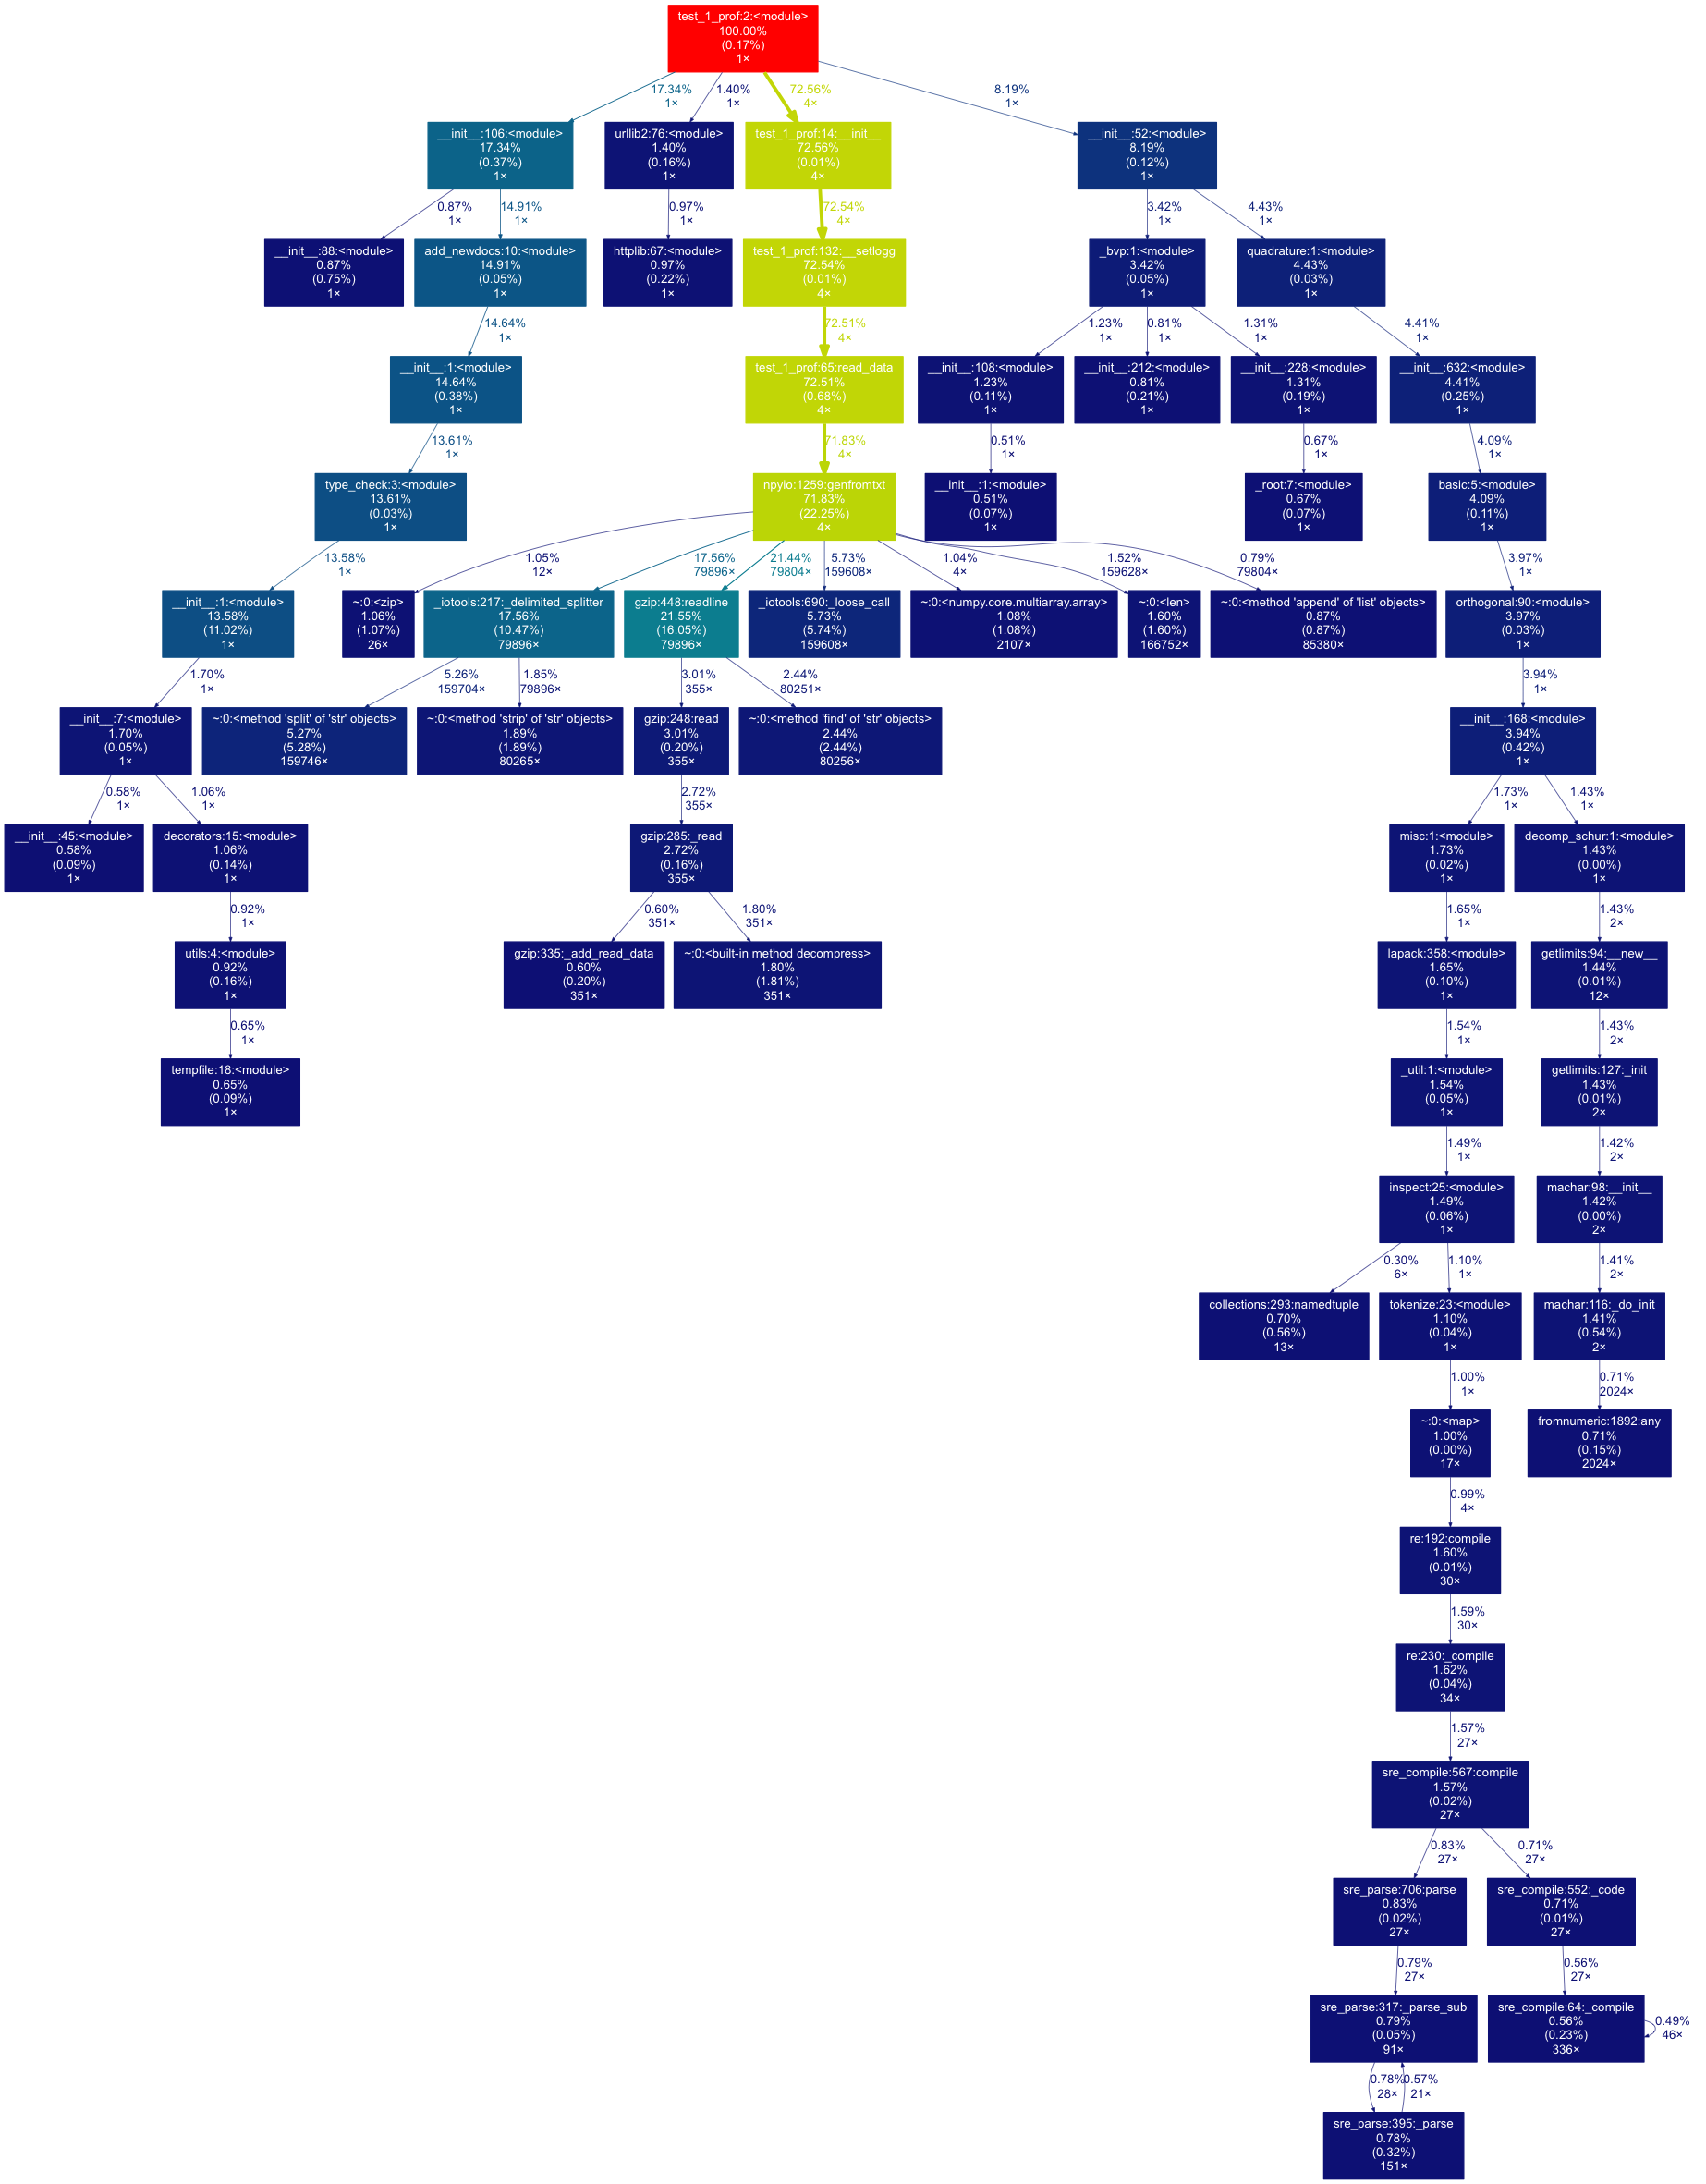

In [19]:
Image(filename='test_1-prof.png')

In [20]:
import pstats
p = pstats.Stats('test_1_prof.prof')
p.strip_dirs().sort_stats('time').print_stats(10);

Wed Oct 26 17:03:03 2016    test_1_prof.prof

         937006 function calls (935967 primitive calls) in 0.733 seconds

   Ordered by: internal time
   List reduced from 1087 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.163    0.041    0.527    0.132 npyio.py:1259(genfromtxt)
    79896    0.118    0.000    0.158    0.000 gzip.py:448(readline)
        6    0.085    0.014    0.214    0.036 __init__.py:1(<module>)
    79896    0.077    0.000    0.129    0.000 _iotools.py:217(_delimited_splitter)
   159608    0.042    0.000    0.042    0.000 _iotools.py:690(_loose_call)
   159746    0.039    0.000    0.039    0.000 {method 'split' of 'str' objects}
    80256    0.018    0.000    0.018    0.000 {method 'find' of 'str' objects}
    80265    0.014    0.000    0.014    0.000 {method 'strip' of 'str' objects}
      351    0.013    0.000    0.013    0.000 {built-in method decompress}
166752/166563    0.012    0.000    0.012

### Profiling the code: RAM memory usage

In [23]:
%%writefile test_3_prof.py

import numpy as np
import os
import urllib2
from scipy.integrate import simps
from memory_profiler import profile

class Stel_Spectrum(object):
    """
    This object downloads a file from http://astro.uni-tuebingen.de/~rauch/TMAF/NLTE/He+C+N+O/
    and is able to make some plots.    
    """
    
    spec_count = 0 # This attibute is at the level of the class, not of the object.
    
    @profile
    def __init__(self, filename=None, T=None, logg=None, verbose=False):
        """
        Initialisation of the Stel_Spectrum object.
        Parameter:
            - filename
            - T: temperature in K, e.g. 150000
            - logg: e.g. 7.5
            - verbose: if True, some info are printed out
        The wl variable is an array of wavelengths in Angstrom.
        The fl variable is the flux in erg/s/cm2/A
        The variables T and logg are properties: changing them will reload the data
        """
        self.verbose = verbose
        if filename is None:
            if T is not None and logg is not None:
                self.__T = T # We need to initialize the hidden values, as logg is still not defined
                self.logg = logg
                self.filename = '0{0:06.0f}_{1:.2f}_33_50_02_15.bin_0.1.gz'.format(self.T, self.logg)
            else:
                raise TypeError("T and logg must be given")
        else:
            self.filename = filename
            self.__T = float(filename.split('_')[0]) # We need to initialize the hidden values, as logg is still not defined
            self.logg = float(filename.split('_')[1])
        Stel_Spectrum.spec_count += 1
        if self.verbose:
            print('Instantiation done')
            
    def dlfile(self):
        """
        Downloading file if not already here. Put it in the current directory
        """
        if not os.path.exists(self.filename):
            if self.verbose:
                print('Downloading {}'.format(self.filename))
            try:
                stel_file = urllib2.urlopen('http://astro.uni-tuebingen.de/~rauch/TMAF/NLTE/He+C+N+O/' + 
                                            self.filename)
                output = open(self.filename,'wb')
                output.write(stel_file.read())
                output.close()
                self.file_found=True
            except:
                if self.verbose:
                    print('file {} not found'.format(self.filename))
                self.file_found=False
        else:
            if self.verbose:
                print('{} already on disk'.format(self.filename))
            self.file_found=True
                
    def read_data(self):
        """
        read the data from the file
        """
        if self.file_found:
            data = np.genfromtxt(self.filename, comments='*', names='wl, fl')
            self.fl = data['fl']
            self.wl = data['wl'] # in A
            self.fl /= 1e8 # F LAMBDA  GIVEN IN ERG/CM**2/SEC/CM -> erg/s/cm2/A
            if self.verbose:
                print('Read data from {}'.format(self.filename))
        else:
            if self.verbose:
                print('file not found {}'.format(self.filename))
            self.wl = None
            self.fl = None
        
    def plot_spr(self, ax=None, *args, **kwargs):
        """
        Plot the spectrum.
        Parameter:
            - ax: an axis (optionnal). If Noe or absent, axis is created
            - any extra parameter is passed to ax.plot
        """
        if self.wl is None:
            print('No data to plot')
            return
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(self.wl, self.fl,
                label='T3={0:.0f}, logg={1}'.format(self.T/1e3, self.logg),
                *args, **kwargs) # Here are the transmissions of extra parameters to plot
        ax.set_yscale('log')
        ax.set_ylim(1e6, 1e14)
        ax.set_xlabel('Wavelength (A)')
        
    @profile
    def get_integ(self):
        """
        Return the integral of Flambda over lambda, in erg/s/cm2
        """
        if self.wl is None:
            print('No data')
            return None
        return simps(self.fl, self.wl) # perform the integral
    
    def __getT(self): 
        return self.__T
    
    def __setT(self, value): 
        if not isinstance(value, (int, long, float)): # check the type of the input
            raise TypeError('T must be an integer or a float')
        if float(value) not in np.linspace(40000, 190000, 16): # check the value of the input
            raise ValueError('T value must be between 40000 and 190000K, by 10000K steps')
        elif self.__T != value:
            self.__T = value
            self.filename = '0{0:06.0f}_{1:.2f}_33_50_02_15.bin_0.1.gz'.format(self.T, self.logg)
            self.dlfile() # will download new data
            self.read_data() # will update the data
        
    def __delT(self): 
        print('T is needed')
        
    T = property(__getT, __setT, __delT, "Stellar effective temperature")
    
    def __getlogg(self): 
        return self.__logg
    
    @profile
    def __setlogg(self, value):
        try:
            self.__logg 
        except:
            self.__logg = -1
        if not isinstance(value, (int, long, float)):
            raise TypeError('logg must be an integer or a float')
        if float(value) not in (-1., 5., 6., 7. ,8., 9.):
            raise ValueError('Error, logg must be 6, 7, 8, or 9')
            self.__logg = None
        elif self.__logg != value:
            self.__logg = value
            self.filename = '0{0:06.0f}_{1:.2f}_33_50_02_15.bin_0.1.gz'.format(self.T, self.logg)
            self.dlfile() # will download new data
            self.read_data() # will update the data
        
    def __dellogg(self): 
        print('logg is needed')
        
    logg = property(__getlogg, __setlogg, __dellogg, "Stellar logg")

    def print_info(self):
        """
        Print out the filename and the number of points
        """
        print self.__repr__()
        
    def __repr__(self):
        """
        This is what is used when calling "print <obj>" or <obj> ENTER
        """
        if self.wl is None:
            return'Filename: {0}, No data'.format(self.filename)
        else:
            return'Filename: {0}, number of points: {1}'.format(self.filename, len(self.wl))
    
    def __del__(self):
        Stel_Spectrum.spec_count -= 1


sp = Stel_Spectrum(T=100000, logg=6, verbose=True)
print('Temperature = {0:.0f}K, Flux = {1:.2e} erg/s/cm2'.format(sp.T, sp.get_integ()))

Overwriting test_3_prof.py


In [24]:
# need to pip install memory_profiler
# need to pip install psutil
!python -m memory_profiler test_3_prof.py 

0100000_6.00_33_50_02_15.bin_0.1.gz already on disk
Read data from 0100000_6.00_33_50_02_15.bin_0.1.gz
Filename: test_3_prof.py

Line #    Mem usage    Increment   Line Contents
   136     45.1 MiB      0.0 MiB       @profile
   137                                 def __setlogg(self, value):
   138     45.1 MiB      0.0 MiB           try:
   139     45.1 MiB      0.0 MiB               self.__logg 
   140     45.1 MiB      0.0 MiB           except:
   141     45.1 MiB      0.0 MiB               self.__logg = -1
   142     45.1 MiB      0.0 MiB           if not isinstance(value, (int, long, float)):
   143                                         raise TypeError('logg must be an integer or a float')
   144     45.1 MiB      0.0 MiB           if float(value) not in (-1., 5., 6., 7. ,8., 9.):
   145                                         raise ValueError('Error, logg must be 6, 7, 8, or 9')
   146                                         self.__logg = None
   147     45.1 MiB      0.0 MiB  

### Debugger

#### From the terminal

In [15]:
# ! ipython -m pdb test_1_prof.py # from a terminal

#### Breakpoint

In [16]:
# import pdb # need to call the debugger at the breakpoint
# Inserting a pdb.set_trace in the __init__ method to stop the program and inspect it

In [25]:
%%writefile test_5_pdb.py
import pdb # This is needed to use the debugger
import numpy as np
import os
import urllib2
from scipy.integrate import simps

class Stel_Spectrum(object):
    """
    This object downloads a file from http://astro.uni-tuebingen.de/~rauch/TMAF/NLTE/He+C+N+O/
    and is able to make some plots.    
    """
    
    spec_count = 0 # This attibute is at the level of the class, not of the object.
    def __init__(self, filename=None, T=None, logg=None, verbose=False):
        """
        Initialisation of the Stel_Spectrum object.
        Parameter:
            - filename
            - T: temperature in K, e.g. 150000
            - logg: e.g. 7.5
            - verbose: if True, some info are printed out
        The wl variable is an array of wavelengths in Angstrom.
        The fl variable is the flux in erg/s/cm2/A
        The variables T and logg are properties: changing them will reload the data
        """
        pdb.set_trace() # THIS IS A BREAKPOINT
        self.verbose = verbose
        if filename is None:
            if T is not None and logg is not None:
                self.__T = T # We need to initialize the hidden values, as logg is still not defined
                self.logg = logg
                self.filename = '0{0:06.0f}_{1:.2f}_33_50_02_15.bin_0.1.gz'.format(self.T, self.logg)
            else:
                raise TypeError("T and logg must be given")
        else:
            self.filename = filename
            self.__T = float(filename.split('_')[0]) # We need to initialize the hidden values, as logg is still not defined
            self.logg = float(filename.split('_')[1])
        Stel_Spectrum.spec_count += 1
        if self.verbose:
            print('Instantiation done')
            
    def dlfile(self):
        """
        Downloading file if not already here. Put it in the current directory
        """
        if not os.path.exists(self.filename):
            if self.verbose:
                print('Downloading {}'.format(self.filename))
            try:
                stel_file = urllib2.urlopen('http://astro.uni-tuebingen.de/~rauch/TMAF/NLTE/He+C+N+O/' + 
                                            self.filename)
                output = open(self.filename,'wb')
                output.write(stel_file.read())
                output.close()
                self.file_found=True
            except:
                if self.verbose:
                    print('file {} not found'.format(self.filename))
                self.file_found=False
        else:
            if self.verbose:
                print('{} already on disk'.format(self.filename))
            self.file_found=True
                
    def read_data(self):
        """
        read the data from the file
        """
        if self.file_found:
            data = np.genfromtxt(self.filename, comments='*', names='wl, fl')
            self.fl = data['fl']
            self.wl = data['wl'] # in A
            self.fl /= 1e8 # F LAMBDA  GIVEN IN ERG/CM**2/SEC/CM -> erg/s/cm2/A
            if self.verbose:
                print('Read data from {}'.format(self.filename))
        else:
            if self.verbose:
                print('file not found {}'.format(self.filename))
            self.wl = None
            self.fl = None
        
    def plot_spr(self, ax=None, *args, **kwargs):
        """
        Plot the spectrum.
        Parameter:
            - ax: an axis (optionnal). If Noe or absent, axis is created
            - any extra parameter is passed to ax.plot
        """
        if self.wl is None:
            print('No data to plot')
            return
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(self.wl, self.fl,
                label='T3={0:.0f}, logg={1}'.format(self.T/1e3, self.logg),
                *args, **kwargs) # Here are the transmissions of extra parameters to plot
        ax.set_yscale('log')
        ax.set_ylim(1e6, 1e14)
        ax.set_xlabel('Wavelength (A)')
        
    def get_integ(self):
        """
        Return the integral of Flambda over lambda, in erg/s/cm2
        """
        if self.wl is None:
            print('No data')
            return None
        return simps(self.fl, self.wl) # perform the integral
    
    def __getT(self): 
        return self.__T
    
    def __setT(self, value): 
        if not isinstance(value, (int, long, float)): # check the type of the input
            raise TypeError('T must be an integer or a float')
        if float(value) not in np.linspace(40000, 190000, 16): # check the value of the input
            raise ValueError('T value must be between 40000 and 190000K, by 10000K steps')
        elif self.__T != value:
            self.__T = value
            self.filename = '0{0:06.0f}_{1:.2f}_33_50_02_15.bin_0.1.gz'.format(self.T, self.logg)
            self.dlfile() # will download new data
            self.read_data() # will update the data
        
    def __delT(self): 
        print('T is needed')
        
    T = property(__getT, __setT, __delT, "Stellar effective temperature")
    
    def __getlogg(self): 
        return self.__logg
    
    def __setlogg(self, value):
        try:
            self.__logg 
        except:
            self.__logg = -1
        if not isinstance(value, (int, long, float)):
            raise TypeError('logg must be an integer or a float')
        if float(value) not in (-1., 5., 6., 7. ,8., 9.):
            raise ValueError('Error, logg must be 6, 7, 8, or 9')
            self.__logg = None
        elif self.__logg != value:
            self.__logg = value
            self.filename = '0{0:06.0f}_{1:.2f}_33_50_02_15.bin_0.1.gz'.format(self.T, self.logg)
            self.dlfile() # will download new data
            self.read_data() # will update the data
        
    def __dellogg(self): 
        print('logg is needed')
        
    logg = property(__getlogg, __setlogg, __dellogg, "Stellar logg")

    def print_info(self):
        """
        Print out the filename and the number of points
        """
        print self.__repr__()
        
    def __repr__(self):
        """
        This is what is used when calling "print <obj>" or <obj> ENTER
        """
        if self.wl is None:
            return'Filename: {0}, No data'.format(self.filename)
        else:
            return'Filename: {0}, number of points: {1}'.format(self.filename, len(self.wl))
    
    def __del__(self):
        Stel_Spectrum.spec_count -= 1

sp = Stel_Spectrum(T=100000, logg=6)
print 'ending'
print sp.filename

Overwriting test_5_pdb.py


The commands that can be used once inside the pdb debugger session are: 
* l(list)	Lists the code at the current position
* u(p)	    Walk up the call stack
* d(own)	Walk down the call stack
* n(ext)	Execute the next line (does not go down in new functions)
* s(tep)	Execute the next statement (goes down in new functions)
* bt	    Print the call stack
* a	        Print the local variables
* !command	Execute the given Python command (by opposition to pdb commands
* break N   Set a breakpoint at line number N. If no N, list all the breakpoints
* disable N Remove the breakpoin number N
* c(ontinue) Run until the next breakpoint or the end of the program
* return   Continues executing until the function is about to execute a return statement, and then it pauses. This gives you time to look at the return value before the function returns.

In [18]:
%run test_5_pdb.py

> /home/morisset/Google Drive/Pro/Python-MySQL/Notebooks/Notebooks/test_5_pdb.py(27)__init__()
-> self.verbose = verbose


KeyboardInterrupt: 

In [28]:
%%writefile test_6_pdb.py
import numpy as np
import os
import urllib2
from scipy.integrate import simps

class Stel_Spectrum(object):
    """
    This object downloads a file from http://astro.uni-tuebingen.de/~rauch/TMAF/NLTE/He+C+N+O/
    and is able to make some plots.    
    """
    
    spec_count = 0 # This attibute is at the level of the class, not of the object.
    def __init__(self, filename=None, T=None, logg=None, verbose=False):
        """
        Initialisation of the Stel_Spectrum object.
        Parameter:
            - filename
            - T: temperature in K, e.g. 150000
            - logg: e.g. 7.5
            - verbose: if True, some info are printed out
        The wl variable is an array of wavelengths in Angstrom.
        The fl variable is the flux in erg/s/cm2/A
        The variables T and logg are properties: changing them will reload the data
        """
        self.verbose = verbose
        if filename is None:
            if T is not None and logg is not None:
                self.__T = T # We need to initialize the hidden values, as logg is still not defined
                self.logg = logg
                self.filename = '0{0:06.0f}_{1:.2f}_33_50_02_15.bin_0.1.gz'.format(self.T, self.logg)
            else:
                raise TypeError("T and logg must be given")
        else:
            self.filename = filename
            self.__T = float(filename.split('_')[0]) # We need to initialize the hidden values, as logg is still not defined
            self.logg = float(filename.split('_')[1])
        Stel_Spectrum.spec_count += 1
        if self.verbose:
            print('Instantiation done')
            
    def dlfile(self):
        """
        Downloading file if not already here. Put it in the current directory
        """
        if not os.path.exists(self.filename):
            if self.verbose:
                print('Downloading {}'.format(self.filename))
            try:
                stel_file = urllib2.urlopen('http://astro.uni-tuebingen.de/~rauch/TMAF/NLTE/He+C+N+O/' + 
                                            self.filename)
                output = open(self.filename,'wb')
                output.write(stel_file.read())
                output.close()
                self.file_found=True
            except:
                if self.verbose:
                    print('file {} not found'.format(self.filename))
                self.file_found=False
        else:
            if self.verbose:
                print('{} already on disk'.format(self.filenames))
            self.file_found=True
                
    def read_data(self):
        """
        read the data from the file
        """
        if self.file_found:
            data = np.genfromtxt(self.filename, comments='*', names='wl, fl')
            self.fl = data['fl']
            self.wl = data['wl'] # in A
            self.fl /= 1e8 # F LAMBDA  GIVEN IN ERG/CM**2/SEC/CM -> erg/s/cm2/A
            if self.verbose:
                print('Read data from {}'.format(self.filename))
        else:
            if self.verbose:
                print('file not found {}'.format(self.filename))
            self.wl = None
            self.fl = None
        
    def plot_spr(self, ax=None, *args, **kwargs):
        """
        Plot the spectrum.
        Parameter:
            - ax: an axis (optionnal). If Noe or absent, axis is created
            - any extra parameter is passed to ax.plot
        """
        if self.wl is None:
            print('No data to plot')
            return
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(self.wl, self.fl,
                label='T3={0:.0f}, logg={1}'.format(self.T/1e3, self.logg),
                *args, **kwargs) # Here are the transmissions of extra parameters to plot
        ax.set_yscale('log')
        ax.set_ylim(1e6, 1e14)
        ax.set_xlabel('Wavelength (A)')
        
    def get_integ(self):
        """
        Return the integral of Flambda over lambda, in erg/s/cm2
        """
        if self.wl is None:
            print('No data')
            return None
        return simps(self.fl, self.wl) # perform the integral
    
    def __getT(self): 
        return self.__T
    
    def __setT(self, value): 
        if not isinstance(value, (int, long, float)): # check the type of the input
            raise TypeError('T must be an integer or a float')
        if float(value) not in np.linspace(40000, 190000, 16): # check the value of the input
            raise ValueError('T value must be between 40000 and 190000K, by 10000K steps')
        elif self.__T != value:
            self.__T = value
            self.filename = '0{0:06.0f}_{1:.2f}_33_50_02_15.bin_0.1.gz'.format(self.T, self.logg)
            self.dlfile() # will download new data
            self.read_data() # will update the data
        
    def __delT(self): 
        print('T is needed')
        
    T = property(__getT, __setT, __delT, "Stellar effective temperature")
    
    def __getlogg(self): 
        return self.__logg
    
    def __setlogg(self, value):
        try:
            self.__logg 
        except:
            self.__logg = -1
        if not isinstance(value, (int, long, float)):
            raise TypeError('logg must be an integer or a float')
        if float(value) not in (-1., 5., 6., 7. ,8., 9.):
            raise ValueError('Error, logg must be 6, 7, 8, or 9')
            self.__logg = None
        elif self.__logg != value:
            self.__logg = value
            self.filename = '0{0:06.0f}_{1:.2f}_33_50_02_15.bin_0.1.gz'.format(self.T, self.logg)
            self.dlfile() # will download new data
            self.read_data() # will update the data
        
    def __dellogg(self): 
        print('logg is needed')
        
    logg = property(__getlogg, __setlogg, __dellogg, "Stellar logg")

    def print_info(self):
        """
        Print out the filename and the number of points
        """
        print self.__repr__()
        
    def __repr__(self):
        """
        This is what is used when calling "print <obj>" or <obj> ENTER
        """
        if self.wl is None:
            return'Filename: {0}, No data'.format(self.filename)
        else:
            return'Filename: {0}, number of points: {1}'.format(self.filename, len(self.wl))
    
    def __del__(self):
        Stel_Spectrum.spec_count -= 1

sp = Stel_Spectrum(T=100000, logg=6, verbose=True)
print 'ending'
print sp.filename

Overwriting test_6_pdb.py
